In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet


In [2]:
df = pd.read_csv('../data/cleaned/cleaned_data.csv')
df.head()

,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,year,month,day,day_of_week,hour,is_weekend,hour_group
0,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015,1,1,3,11,False,Morning
1,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015,1,1,3,11,False,Morning
2,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015,1,1,3,11,False,Morning
3,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015,1,1,3,11,False,Morning
4,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015,1,1,3,11,False,Morning


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   quantity           48620 non-null  int64  
 1   order_date         48620 non-null  object 
 2   order_time         48620 non-null  object 
 3   unit_price         48620 non-null  float64
 4   total_price        48620 non-null  float64
 5   pizza_size         48620 non-null  object 
 6   pizza_category     48620 non-null  object 
 7   pizza_ingredients  48620 non-null  object 
 8   pizza_name         48620 non-null  object 
 9   year               48620 non-null  int64  
 10  month              48620 non-null  int64  
 11  day                48620 non-null  int64  
 12  day_of_week        48620 non-null  int64  
 13  hour               48620 non-null  int64  
 14  is_weekend         48620 non-null  bool   
 15  hour_group         48620 non-null  object 
dtypes: bool(1), float64(2)

In [4]:
df['order_date'] = pd.to_datetime(df['order_date'])
daily_data = df.groupby('order_date')['total_price'].sum().reset_index()
daily_data = daily_data.set_index('order_date')

daily_data.isna().sum()

total_price    0
dtype: int64

In [5]:
full_date_range = pd.date_range(start=daily_data.index.min(), end=daily_data.index.max(), freq='D')
missing_dates = full_date_range.difference(daily_data.index)
len(missing_dates)


204

Total 204 missing Dates need to fill those

In [6]:
daily_data = daily_data.reindex(full_date_range, fill_value=0)
daily_data.index.name = 'order_date'
daily_data

,total_price
order_date,
2015-01-01,2713.85
2015-01-02,2731.90
2015-01-03,2662.40
2015-01-04,1755.45
2015-01-05,2065.95
...,...
2015-12-08,1856.25
2015-12-09,2571.55
2015-12-10,1985.60


In [7]:
full_date_range = pd.date_range(start=daily_data.index.min(), end=daily_data.index.max(), freq='D')
missing_dates = full_date_range.difference(daily_data.index)
len(missing_dates)

0

Text(0, 0.5, 'Sales $')

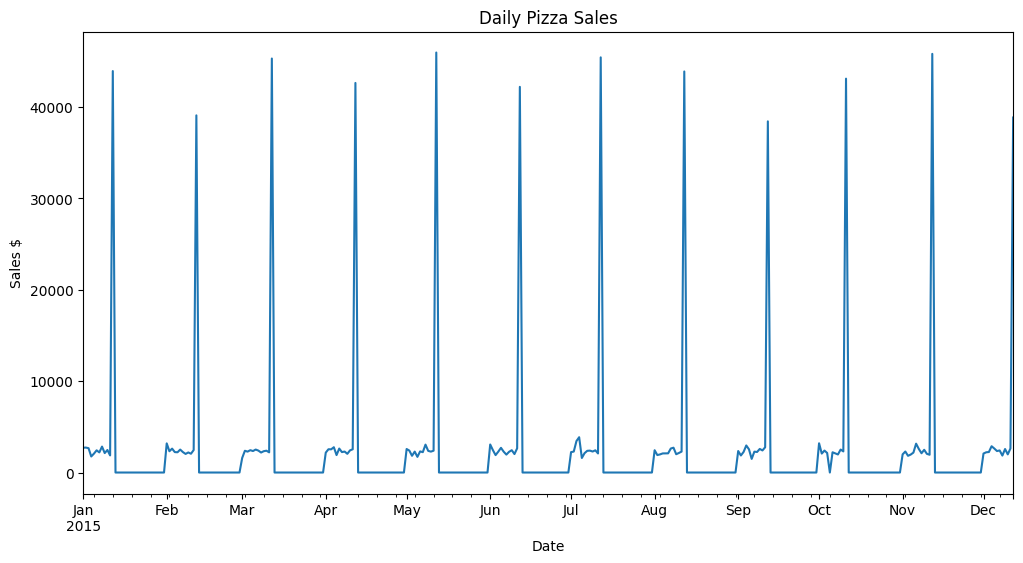

In [8]:
daily_data['total_price'].plot(figsize=(12, 6), title='Daily Pizza Sales')
plt.xlabel('Date')
plt.ylabel('Sales $')

In [9]:
decomposition = seasonal_decompose(x=daily_data, model='additive', period=7)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
org = decomposition.observed

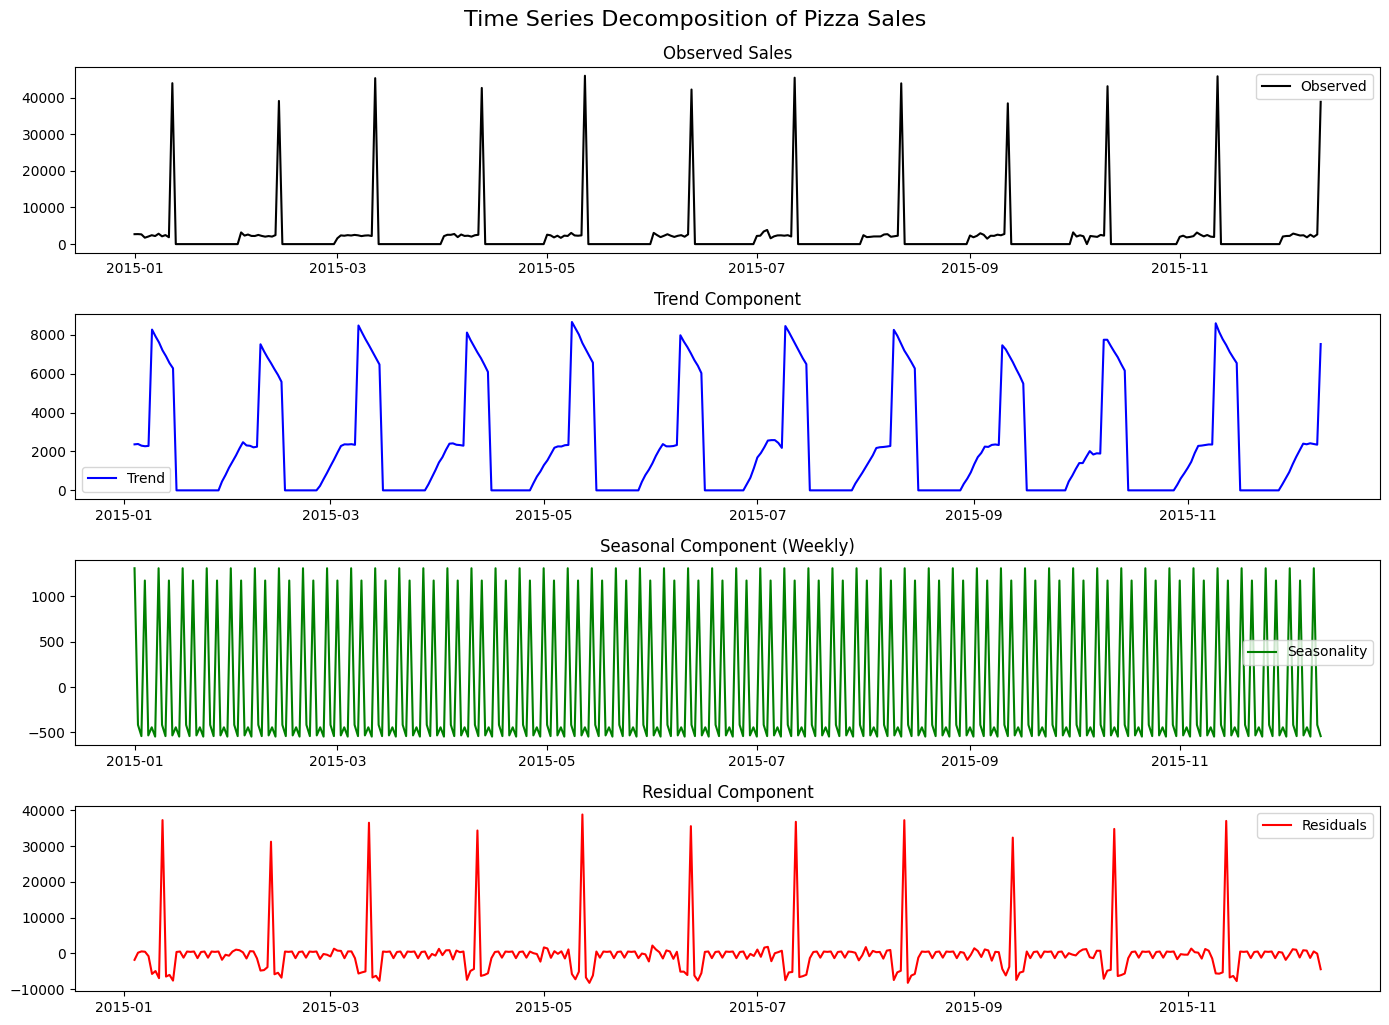

In [10]:
plt.figure(figsize=(14, 10))

# Observed
plt.subplot(4, 1, 1)
plt.plot(org, label='Observed', color='black')
plt.title('Observed Sales')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component (Weekly)')
plt.legend()

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.suptitle("Time Series Decomposition of Pizza Sales", fontsize=16, y=1.02)
plt.show()


Stationarity Test

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(daily_data['total_price'])

print(f'ADF Statistic {round(adf_test[0],3)}')
print(f'p-value: {round(adf_test[1],3)}')
print(f'Critical Values: ')
for key, value in adf_test[4].items():
  print(f'  {key}: {round(value, 3)} ')

ADF Statistic -17.926
p-value: 0.0
Critical Values: 
  1%: -3.449 
  5%: -2.87 
  10%: -2.571 


In [12]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(daily_data['total_price'].diff().dropna())

print(f'KPSS Statistic {round(kpss_test[0],3)}')
print(f'p-value: {round(kpss_test[1],3)}')
print(f'Critical Values: ')
for key, value in kpss_test[3].items():
  print(f'  {key}: {round(value, 3)} ')

KPSS Statistic 0.271
p-value: 0.1
Critical Values: 
  10%: 0.347 
  5%: 0.463 
  2.5%: 0.574 
  1%: 0.739 


/var/folders/l1/kcfsdr451n98nd8gxcg2bzgw0000gn/T/ipykernel_35326/869666170.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(daily_data['total_price'].diff().dropna())


The data is stationary

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(daily_data, lags=[10], return_df=True)
print(ljung_box)


     lb_stat  lb_pvalue
10  0.848433   0.999919


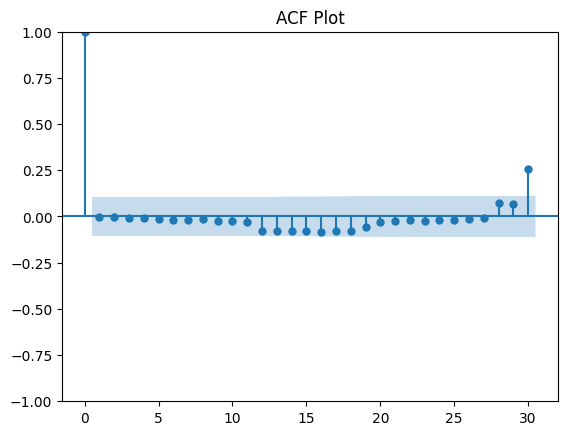

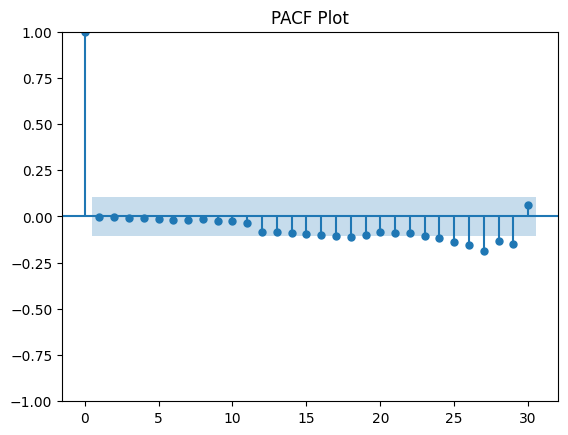

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(daily_data, lags=30)
plt.title("ACF Plot")
plt.show()

plot_pacf(daily_data, lags=30)
plt.title("PACF Plot")
plt.show()


In [15]:
weekly_sales = df.groupby(pd.Grouper(key='order_date', freq='W'))['total_price'].sum()

In [16]:
full_date_range = pd.date_range(start=weekly_sales.index.min(), end=weekly_sales.index.max(), freq='W')
missing_dates = full_date_range.difference(weekly_sales.index)
len(missing_dates)


0

In [17]:
weekly_sales = weekly_sales.asfreq('W').fillna(0)
weekly_sales.index.name = 'week_start_date'

In [18]:
len(weekly_sales)

50

Text(0, 0.5, 'Total Sales ($)')

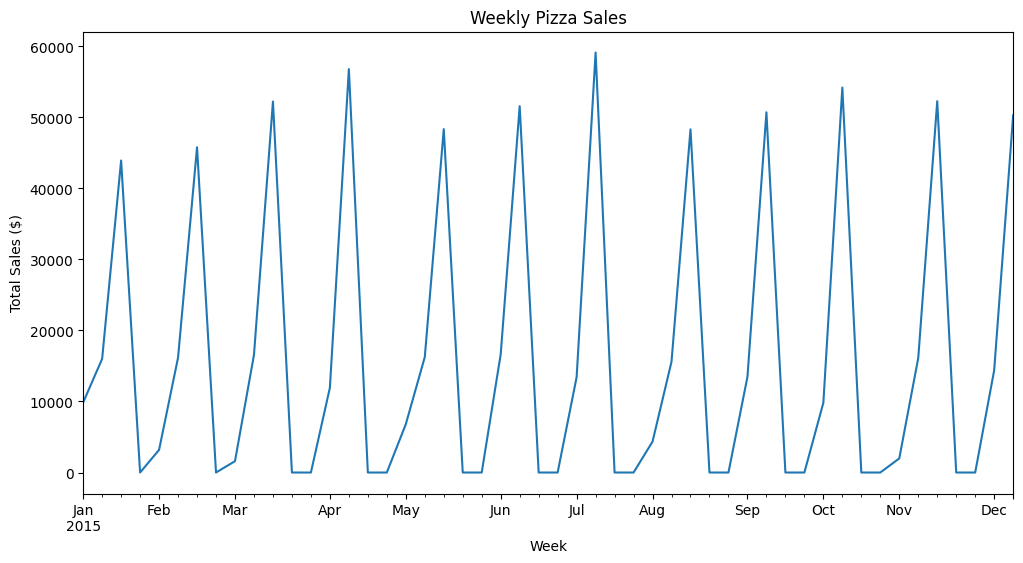

In [19]:
weekly_sales.plot(figsize=(12, 6), title='Weekly Pizza Sales')
plt.xlabel('Week')
plt.ylabel('Total Sales ($)')

In [20]:
decomposition = seasonal_decompose(x=weekly_sales, model='additive', period=12)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
org = decomposition.observed

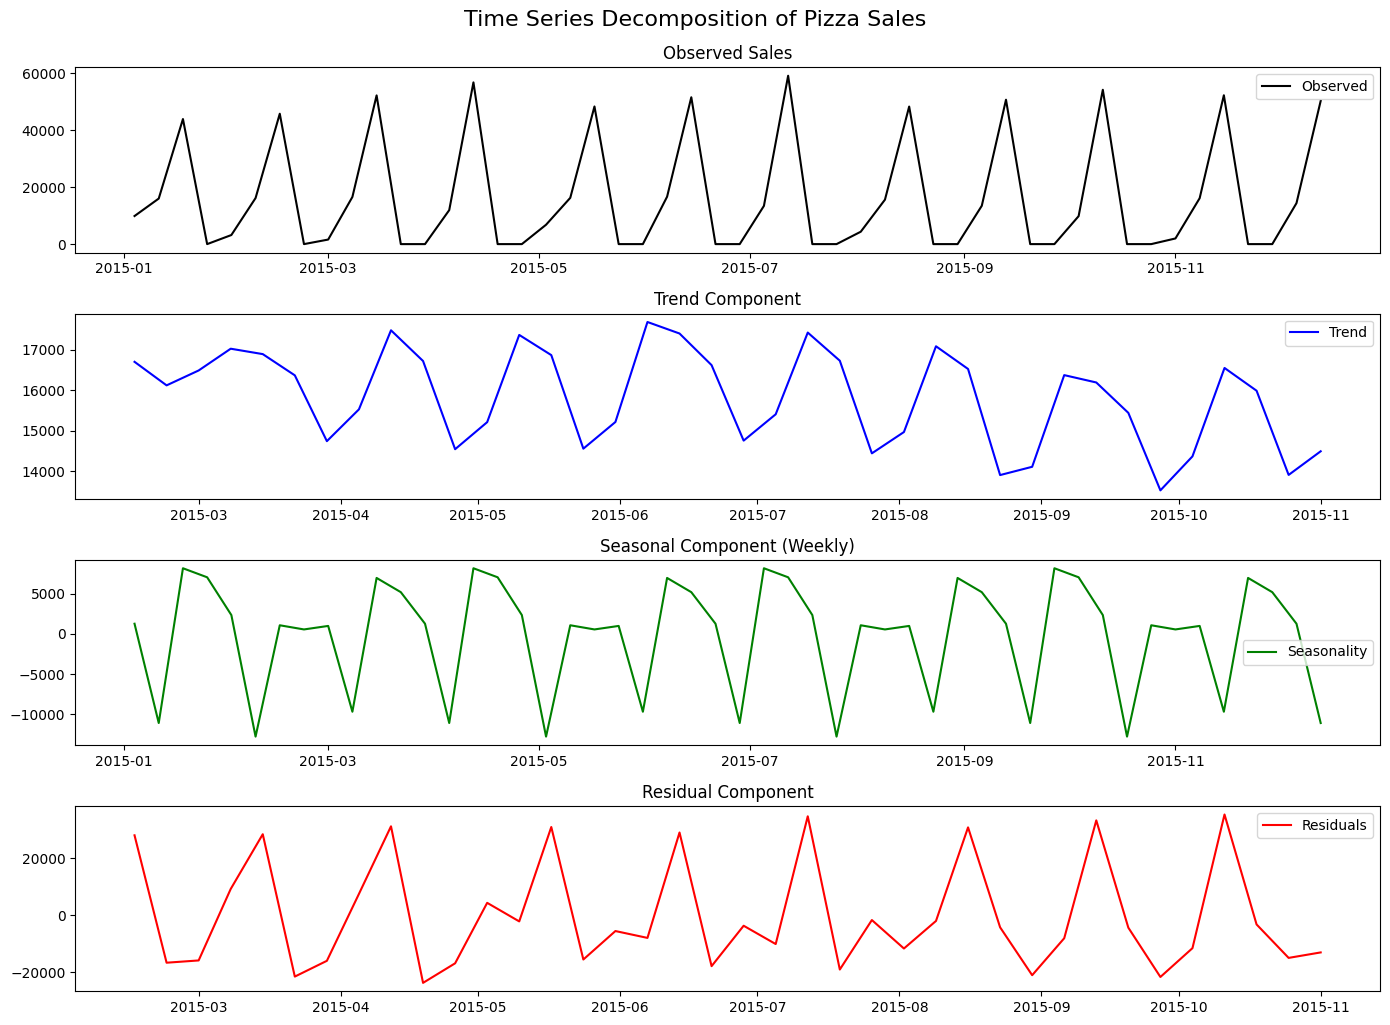

In [21]:
plt.figure(figsize=(14, 10))

# Observed
plt.subplot(4, 1, 1)
plt.plot(org, label='Observed', color='black')
plt.title('Observed Sales')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component (Weekly)')
plt.legend()

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.suptitle("Time Series Decomposition of Pizza Sales", fontsize=16, y=1.02)
plt.show()


In [22]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(weekly_sales)

print(f'ADF Statistic {round(adf_test[0],3)}')
print(f'p-value: {round(adf_test[1],3)}')
print(f'Critical Values: ')
for key, value in adf_test[4].items():
  print(f'  {key}: {round(value, 3)} ')

ADF Statistic -3.824
p-value: 0.003
Critical Values: 
  1%: -3.616 
  5%: -2.941 
  10%: -2.609 


In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(weekly_sales, lags=[10], return_df=True)
print(ljung_box)


      lb_stat     lb_pvalue
10  84.257378  7.312058e-14


In [24]:
decomposition = seasonal_decompose(x=weekly_sales, model='additive', period=4)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
org = decomposition.observed

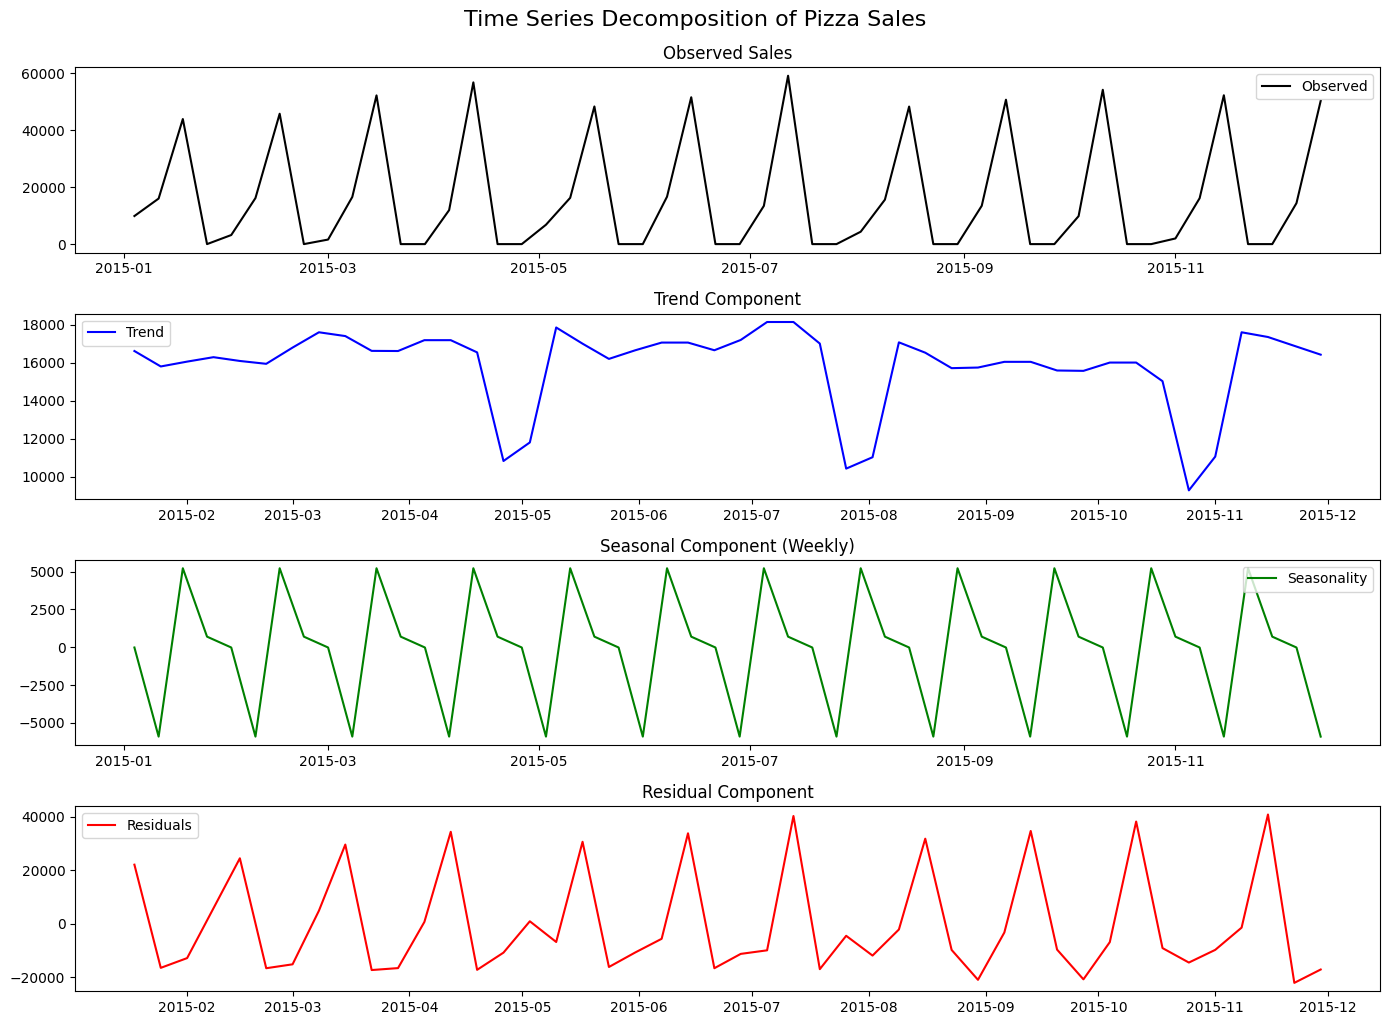

In [25]:
plt.figure(figsize=(14, 10))

# Observed
plt.subplot(4, 1, 1)
plt.plot(org, label='Observed', color='black')
plt.title('Observed Sales')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component (Weekly)')
plt.legend()

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.suptitle("Time Series Decomposition of Pizza Sales", fontsize=16, y=1.02)
plt.show()


In [26]:
prophet_df = weekly_sales.reset_index()
prophet_df.columns = ['ds', 'y']

In [27]:
prophet_df['ds'].max()

Timestamp('2015-12-13 00:00:00')

In [28]:
model = Prophet()

# Fit the model
model.fit(prophet_df)

11:15:17 - cmdstanpy - INFO - Chain [1] start processing
11:15:17 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = model.make_future_dataframe(periods=12, freq='W')

# Generate forecast
forecast = model.predict(future)

In [30]:
print(future.tail())

           ds
57 2016-02-07
58 2016-02-14
59 2016-02-21
60 2016-02-28
61 2016-03-06


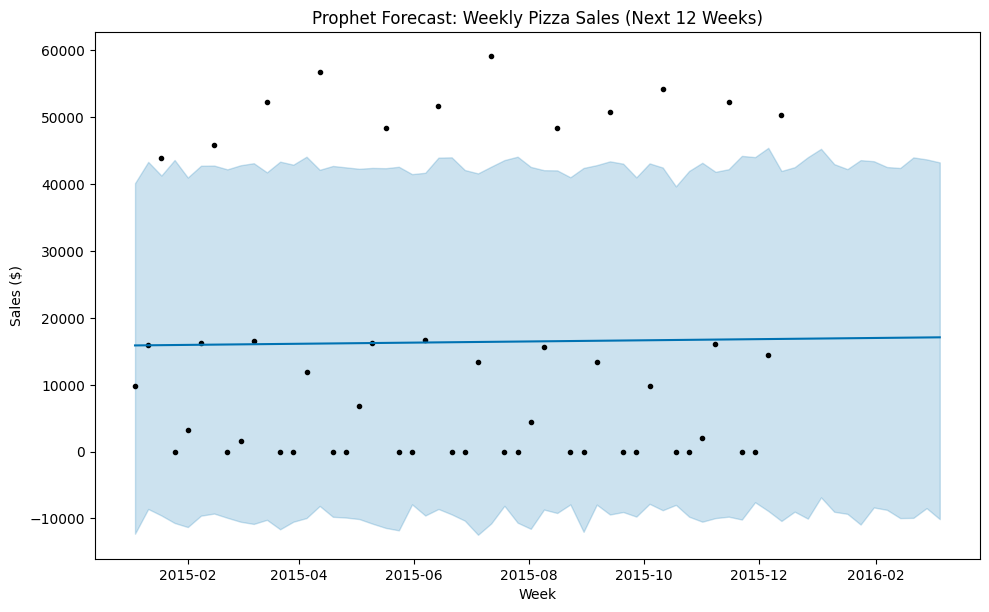

In [31]:

fig1 = model.plot(forecast)
plt.title("Prophet Forecast: Weekly Pizza Sales (Next 12 Weeks)")
plt.xlabel("Week")
plt.ylabel("Sales ($)")
plt.grid()
plt.show()

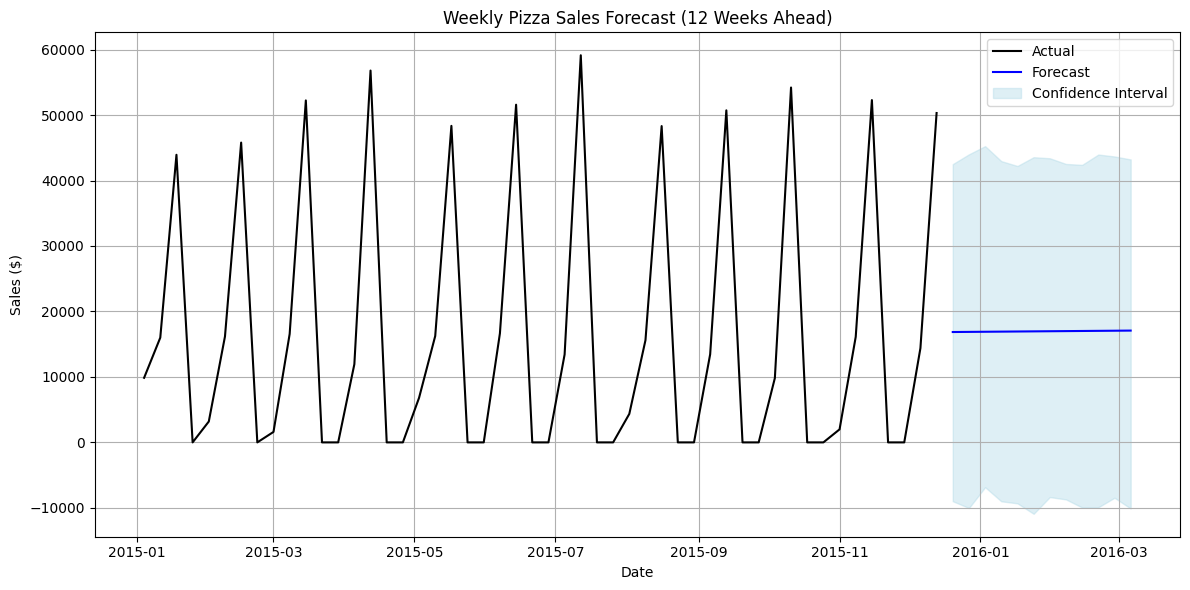

In [33]:
# Split forecast into actual and future
last_train_date = prophet_df['ds'].max()
forecast_train = forecast[forecast['ds'] <= last_train_date]
forecast_future = forecast[forecast['ds'] > last_train_date]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', color='black')
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_future['ds'], 
                 forecast_future['yhat_lower'], 
                 forecast_future['yhat_upper'], 
                 color='lightblue', alpha=0.4, label='Confidence Interval')
plt.title("Weekly Pizza Sales Forecast (12 Weeks Ahead)")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
df['order_date'] = pd.to_datetime(df['order_date'])
df.set_index('order_date', inplace=True)

monthly_sales = df['total_price'].resample('M').sum()


/var/folders/l1/kcfsdr451n98nd8gxcg2bzgw0000gn/T/ipykernel_35326/1166472529.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['total_price'].resample('M').sum()


In [ ]:
# Create full date range for monthly frequency
full_month_range = pd.date_range(start=monthly_sales.index.min(), 
                                 end=monthly_sales.index.max(), freq='M')

# Find missing months
missing_months = full_month_range.difference(monthly_sales.index)
print("Missing months:", missing_months)

Missing months: DatetimeIndex([], dtype='datetime64[ns]', freq='ME')


/var/folders/l1/kcfsdr451n98nd8gxcg2bzgw0000gn/T/ipykernel_35326/3152351645.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_month_range = pd.date_range(start=monthly_sales.index.min(),


/var/folders/l1/kcfsdr451n98nd8gxcg2bzgw0000gn/T/ipykernel_35326/3920836987.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['total_price'].resample('M').sum()


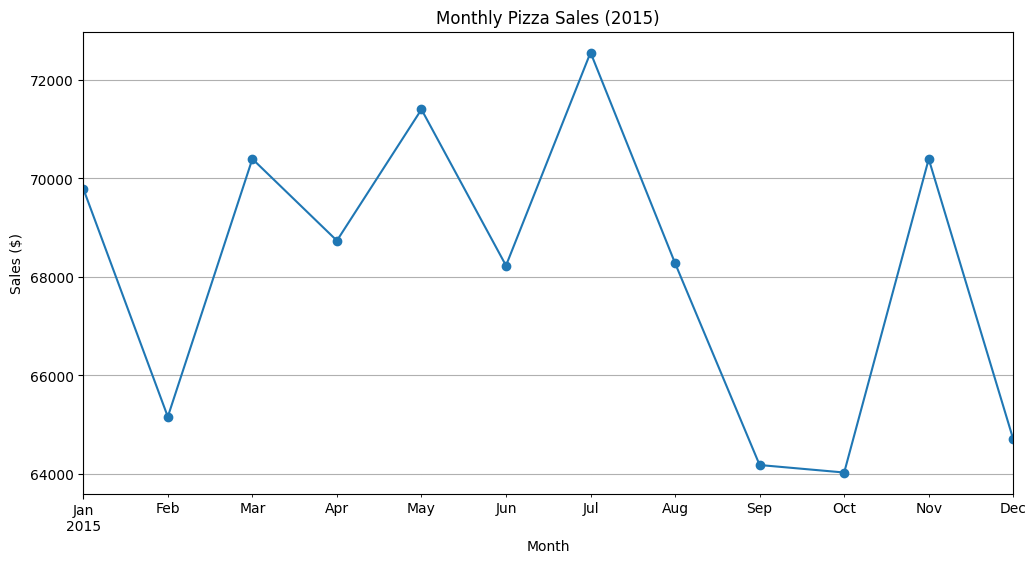

In [37]:
monthly_sales = df['total_price'].resample('M').sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Pizza Sales (2015)')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.grid(True)
plt.show()


In [41]:
monthly_sales = df['total_price'].resample('M').sum().reset_index()
prophet_df = monthly_sales.rename(columns={'order_date': 'ds', 'total_price': 'y'})

model = Prophet(
    yearly_seasonality=False, 
    weekly_seasonality=False,
    daily_seasonality=False
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)


model.fit(prophet_df)

/var/folders/l1/kcfsdr451n98nd8gxcg2bzgw0000gn/T/ipykernel_35326/943749600.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['total_price'].resample('M').sum().reset_index()
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)


/Users/adityakumbhar/Developer/Pizza Sales Forecasting/.venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


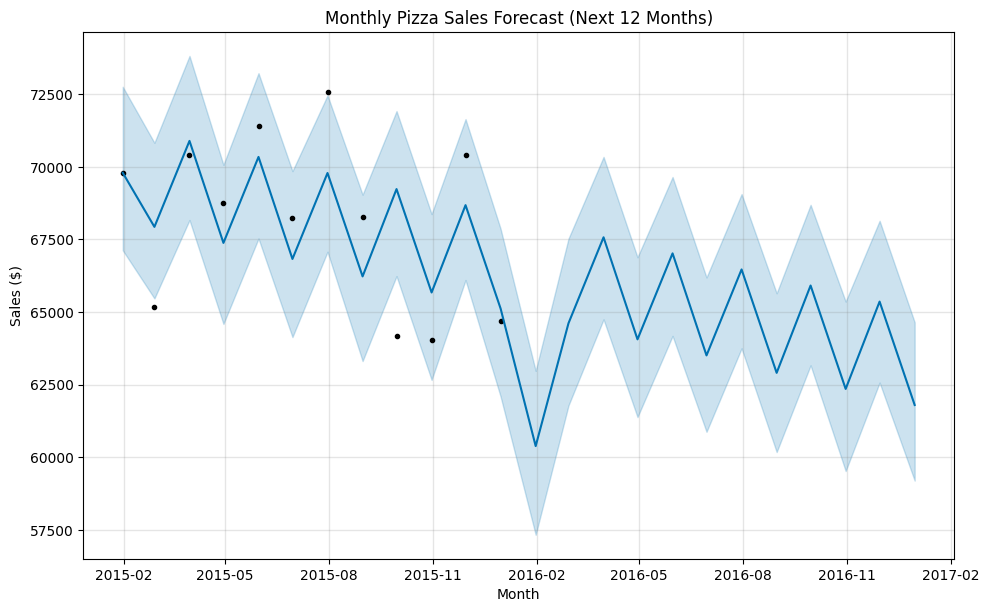

In [43]:
# Plot the forecast
fig = model.plot(forecast)
plt.title("Monthly Pizza Sales Forecast (Next 12 Months)")
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.grid(True)
plt.show()


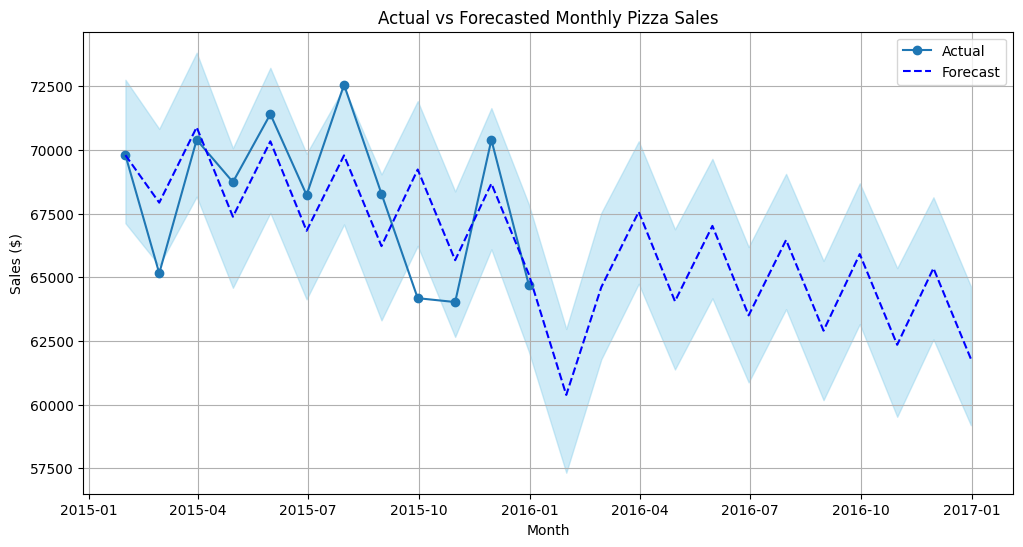

In [44]:
# Plot actual and forecast
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.4)
plt.title("Actual vs Forecasted Monthly Pizza Sales")
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
actual = prophet_df.set_index('ds')
predicted = forecast.set_index('ds').loc[actual.index]


mae = mean_absolute_error(actual['y'], predicted['' 'yhat'])
rmse = sqrt(mean_squared_error(actual['y'], predicted['yhat']))
mape = (abs((actual['y'] - predicted['yhat']) / actual['y'])).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 1729.17
RMSE: 2162.57
MAPE: 2.57%
